# Assignment 1: Sampling and Reproducibility

The code at the end of this file explores contact tracing data about an outbreak of the flu, and demonstrates the dangers of incomplete and non-random samples. This assignment is modified from [Contact tracing can give a biased sample of COVID-19 cases](https://andrewwhitby.com/2020/11/24/contact-tracing-biased/) by Andrew Whitby.

Examine the code below. Identify all stages at which sampling is occurring in the model. Describe in words the sampling procedure, referencing the functions used, sample size, sampling frame, any underlying distributions involved. 


These are the 3 main sampling steps occurring in the code:
1. Infection:
  - `infected_indices = np.random.choice(ppl.index, size=int(len(ppl) * ATTACK_RATE), replace=False)`

    - This is where simple random sampling is occuring. `np.random.choice(...)` is the function used. 

    - Sample size: 100
  
    - Sampling frame: 1000
  
    - Underlying distributions: Uniform distribution --> when every event in the situation has an equal chance of happening ie. every person in the sample has equal chance of being infected.

2. Primary Contact Tracing:
  - `ppl.loc[ppl['infected'], 'traced'] = np.random.rand(sum(ppl['infected'])) < TRACE_SUCCESS`
  
    - `np.random.rand(...)` is the function used.
  
    - Sample size: subset of infected individuals who we selected to be traced (sampling)
  
    - Sampling frame: 100 infected individuals
  
    - Underlying distributions: Binomial --> Traced vs. Not traced

3. Secondary Contact Tracing: 
  - `event_trace_counts = ppl[ppl['traced'] == True]['event'].value_counts()`
  - `events_traced = event_trace_counts[event_trace_counts >= SECONDARY_TRACE_THRESHOLD].index`
  
    - We're just counting the # of events, not really sampling.

    - Sample size: We are sampling the # of events (weddings or brunches) with which >=2 individuals were successfully traced.
  
    - Sampling frame: The total # of people that were successfully traced at either weddings or brunches
  
    - Underlying distributions: No underlying distribution

Modify the number of repetitions in the simulation to 10 and 100 (from the original 1000). Run the script multiple times and observe the outputted graphs. Comment on the reproducibility of the results.

The results differ every time I run the code so there isn't any reproducibility in the results at all.

Alter the code so that it is reproducible. Describe the changes you made to the code and how they affected the reproducibility of the script. The output needs to produce the same output when run multiple times.

I set the random seed to 2 with np.random.seed(2), which allowed the results to be reproducible.

## Code

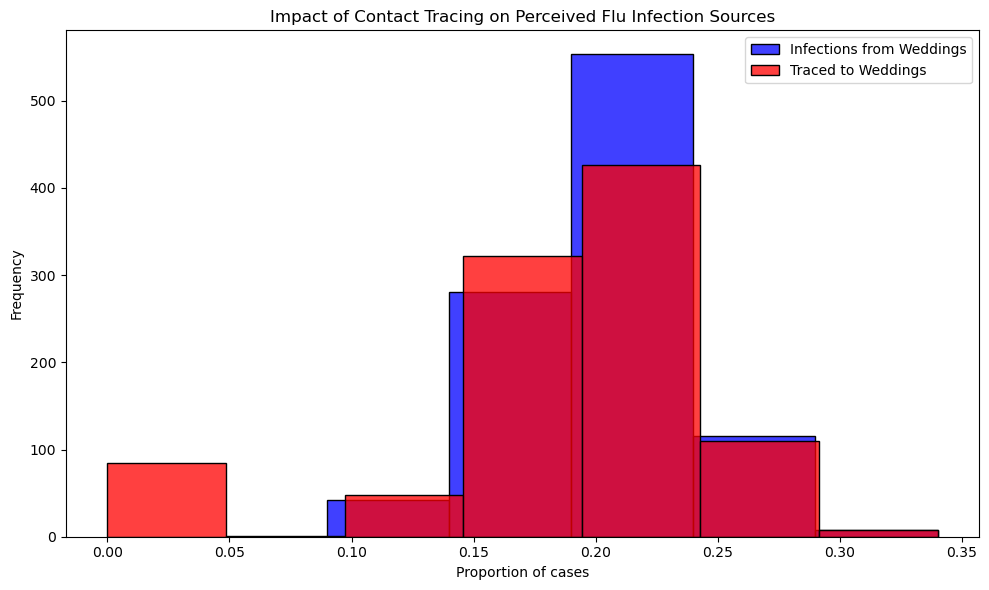

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Note: Suppressing FutureWarnings to maintain a clean output. This is specifically to ignore warnings about
# deprecated features in the libraries we're using (e.g., 'use_inf_as_na' option in Pandas, used by Seaborn),
# which we currently have no direct control over. This action is taken to ensure that our output remains
# focused on relevant information, acknowledging that we rely on external library updates to fully resolve
# these deprecations. Always consider reviewing and removing this suppression after significant library updates.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Constants representing the parameters of the model (hypothetical #s: experimental design)
ATTACK_RATE = 0.10
TRACE_SUCCESS = 0.20
SECONDARY_TRACE_THRESHOLD = 2

def simulate_event(m):
  """
  Simulates the infection and tracing process for a series of events.
  
  This function creates a DataFrame representing individuals attending weddings and brunches,
  infects a subset of them based on the ATTACK_RATE, performs primary and secondary contact tracing,
  and calculates the proportions of infections and traced cases that are attributed to weddings.
  
  Parameters:
  - m: Dummy parameter for iteration purposes.
  - tells the function how many times (iterations) I want to simulate this event.
  
  Returns:
  - A tuple containing the proportion of infections and the proportion of traced cases
    that are attributed to weddings.
  """
  # Create DataFrame for people at events with initial infection and traced status
  events = ['wedding'] * 200 + ['brunch'] * 800
  ppl = pd.DataFrame({
      'event': events, # setting up a dataframe with event as a column of 200 weddings & 800 brunches
      'infected': False, # infected column false for every one as we are starting the experiment 
      'traced': np.nan  # Initially setting traced status as NaN (missing value), if we just put NaN -> pandas takes this as a string
  })


  # Explicitly set 'traced' column to nullable boolean type, 
  # since after we run experiment, the traced values will be either T or F, so we're just telling python it's a boolean val
  ppl['traced'] = ppl['traced'].astype(pd.BooleanDtype())


  # Infect a random subset of people
  infected_indices = np.random.choice(ppl.index, size=int(len(ppl) * ATTACK_RATE), replace=False)
  # np.random.choice(...) -> generating random numbers
  # len(ppl) * ATTACK_RATE -> comes out to be 100.0
  # randomly select 100 #'s from ppl.index in btwn 1-1000, don't repeat your selection
  ppl.loc[infected_indices, 'infected'] = True


  # Primary contact tracing: randomly decide which infected people get traced
  ppl.loc[ppl['infected'], 'traced'] = np.random.rand(sum(ppl['infected'])) < TRACE_SUCCESS
  # out of those 100 infected patients, i'm assigning 20% traced successfully (T); 80% are not traced successfully (F)
  # illustrating binomial distribution (?)
  
  # sum(ppl['infected']) -> 100 infected or True's
  # np.random.rand(5) -> generate 5 random float's btwn [0-1] -> 0.1, 0.4, 0.5, 0.5, 0.9
  
  # ppl.loc[row, col]
  # we are selectiong only the traced col's, where the infected row is True
  # row option: ppl['infected'] -> T or F
  # col option: 'traced'

 


  # Secondary contact tracing based on event attendance
  event_trace_counts = ppl[ppl['traced'] == True]['event'].value_counts()
  # we are counting the # of successfully traced patients who were at either wedding or brunch
  # print(event_trace_counts)

  # counting the # of patients that were traced successfully that went to either a wedding or brunch
  events_traced = event_trace_counts[event_trace_counts >= SECONDARY_TRACE_THRESHOLD].index
  # print(events_traced)
  ppl.loc[ppl['event'].isin(events_traced) & ppl['infected'], 'traced'] = True
  # if there are >= 2 infected individuals at either wedding or brunch, set the traced col to True
  # ppl.loc[row, col] 


  # Calculate proportions of infections and traces attributed to each event type
  ppl['event_type'] = ppl['event'].str[0]  # 'w' for wedding, 'b' for brunch
  # we're creating a new col "event_type" with either "w" for wedding or "b" for brunch
  # under the event column, it would say either "wedding" or "brunch", then attach the 1st character -> either "w" or "b"
  
  wedding_infections = sum(ppl['infected'] == True & (ppl['event_type'] == 'w'))
  # sum of those that are 'infected == True' & 'wedding' -> # of ppl that are infected & went to wedding
  brunch_infections = sum(ppl['infected'] & (ppl['event_type'] == 'b'))
  p_wedding_infections = wedding_infections / (wedding_infections + brunch_infections)


  wedding_traces = sum(ppl['infected'] & ppl['traced'] & (ppl['event_type'] == 'w'))
  brunch_traces = sum(ppl['infected'] & ppl['traced'] & (ppl['event_type'] == 'b'))
  p_wedding_traces = wedding_traces / (wedding_traces + brunch_traces)


  return p_wedding_infections, p_wedding_traces

# Run the simulation 1000 times

results = [simulate_event(m) for m in range(1000)]
# returns a tuple of (probability of wedding infections, probability of wedding traces)
# above is called "List Cpmprehension": shortened version of for loop, essentially running function simulate_event from 1 to 1000
# this would return:
# results = [(p_wedding_infections, p_wedding_traces), (p_wedding_infections, p_wedding_traces), (p_wedding_infections, p_wedding_traces)] 
props_df = pd.DataFrame(results, columns=["Infections", "Traces"])
# since results returns a DataFrame of tuples ie. (0.02, 0.01)... columns=["Infections","Traces"] just puts the first float into Infections, etc...

# Plotting the results
plt.figure(figsize=(10, 6))
sns.histplot(props_df['Infections'], color="blue", alpha=0.75, binwidth=0.05, kde=False, label='Infections from Weddings')
sns.histplot(props_df['Traces'], color="red", alpha=0.75, binwidth=0.05, kde=False, label='Traced to Weddings')
plt.xlabel("Proportion of cases")
plt.ylabel("Frequency")
plt.title("Impact of Contact Tracing on Perceived Flu Infection Sources")
plt.legend()
plt.tight_layout()
plt.show()


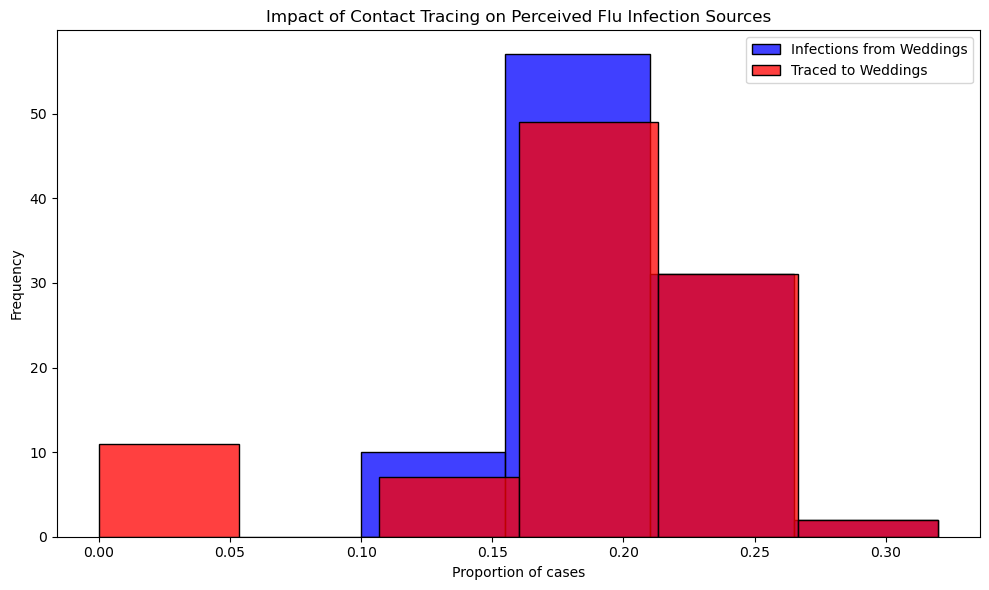

In [50]:
# Constants representing the parameters of the model (hypothetical #s: experimental design)
ATTACK_RATE = 0.10
TRACE_SUCCESS = 0.20
SECONDARY_TRACE_THRESHOLD = 2

def simulate_event(m):
  """
  Simulates the infection and tracing process for a series of events.
  
  This function creates a DataFrame representing individuals attending weddings and brunches,
  infects a subset of them based on the ATTACK_RATE, performs primary and secondary contact tracing,
  and calculates the proportions of infections and traced cases that are attributed to weddings.
  
  Parameters:
  - m: Dummy parameter for iteration purposes.
  - tells the function how many times (iterations) I want to simulate this event.
  
  Returns:
  - A tuple containing the proportion of infections and the proportion of traced cases
    that are attributed to weddings.
  """
  # Create DataFrame for people at events with initial infection and traced status
  events = ['wedding'] * 200 + ['brunch'] * 800
  ppl = pd.DataFrame({
      'event': events, # setting up a dataframe with event as a column of 200 weddings & 800 brunches
      'infected': False, # infected column false for every one as we are starting the experiment 
      'traced': np.nan  # Initially setting traced status as NaN (missing value), if we just put NaN -> pandas takes this as a string
  })


  # Explicitly set 'traced' column to nullable boolean type, 
  # since after we run experiment, the traced values will be either T or F, so we're just telling python it's a boolean val
  ppl['traced'] = ppl['traced'].astype(pd.BooleanDtype())


  # Infect a random subset of people
  infected_indices = np.random.choice(ppl.index, size=int(len(ppl) * ATTACK_RATE), replace=False)
  # np.random.choice(...) -> generating random numbers
  # len(ppl) * ATTACK_RATE -> comes out to be 100.0
  # randomly select 100 #'s from ppl.index in btwn 1-1000, don't repeat your selection
  ppl.loc[infected_indices, 'infected'] = True


  # Primary contact tracing: randomly decide which infected people get traced
  ppl.loc[ppl['infected'], 'traced'] = np.random.rand(sum(ppl['infected'])) < TRACE_SUCCESS
  # out of those 100 infected patients, 20% are traced successfully (T); 80% are not traced successfully (F)
  # illustrating binomial distribution (?)
  
  # ppl.loc[row, col]
  # we are selectiong only the traced col's, where the infected row is True
  # row option: ppl['infected'] -> T or F
  # col option: 'traced'

  # sum(ppl['infected']) -> 100 infected or True's
  # np.random.rand(...) -> generate a random integer btwn 1-100  


  # Secondary contact tracing based on event attendance
  event_trace_counts = ppl[ppl['traced'] == True]['event'].value_counts()
  # we are counting the # of successfully traced patients who were at either wedding or brunch
  # print(event_trace_counts)

  # counting the # of patients that were traced successfully that went to either a wedding or brunch
  events_traced = event_trace_counts[event_trace_counts >= SECONDARY_TRACE_THRESHOLD].index
  # print(events_traced)
  ppl.loc[ppl['event'].isin(events_traced) & ppl['infected'], 'traced'] = True
  # if there are >= 2 infected individuals at either wedding or brunch, set the traced col to True
  # ppl.loc[row, col] 


  # Calculate proportions of infections and traces attributed to each event type
  ppl['event_type'] = ppl['event'].str[0]  # 'w' for wedding, 'b' for brunch
  wedding_infections = sum(ppl['infected'] & (ppl['event_type'] == 'w'))
  brunch_infections = sum(ppl['infected'] & (ppl['event_type'] == 'b'))
  p_wedding_infections = wedding_infections / (wedding_infections + brunch_infections)


  wedding_traces = sum(ppl['infected'] & ppl['traced'] & (ppl['event_type'] == 'w'))
  brunch_traces = sum(ppl['infected'] & ppl['traced'] & (ppl['event_type'] == 'b'))
  p_wedding_traces = wedding_traces / (wedding_traces + brunch_traces)


  return p_wedding_infections, p_wedding_traces

# Run the simulation 100 times

results = [simulate_event(m) for m in range(100)]
# returns a tuple of (probability of wedding infections, probability of wedding traces)
# above is called "List Cpmprehension": shortened version of for loop, essentially running function simulate_event from 1 to 1000
# this would return:
# results = [(p_wedding_infections, p_wedding_traces), (p_wedding_infections, p_wedding_traces), (p_wedding_infections, p_wedding_traces)] 
props_df = pd.DataFrame(results, columns=["Infections", "Traces"])
# since results returns a DataFrame of tuples ie. (0.02, 0.01)... columns=["Infections","Traces"] just puts the first float into Infections, etc...

# Plotting the results
plt.figure(figsize=(10, 6))
sns.histplot(props_df['Infections'], color="blue", alpha=0.75, binwidth=0.05, kde=False, label='Infections from Weddings')
sns.histplot(props_df['Traces'], color="red", alpha=0.75, binwidth=0.05, kde=False, label='Traced to Weddings')
plt.xlabel("Proportion of cases")
plt.ylabel("Frequency")
plt.title("Impact of Contact Tracing on Perceived Flu Infection Sources")
plt.legend()
plt.tight_layout()
plt.show()


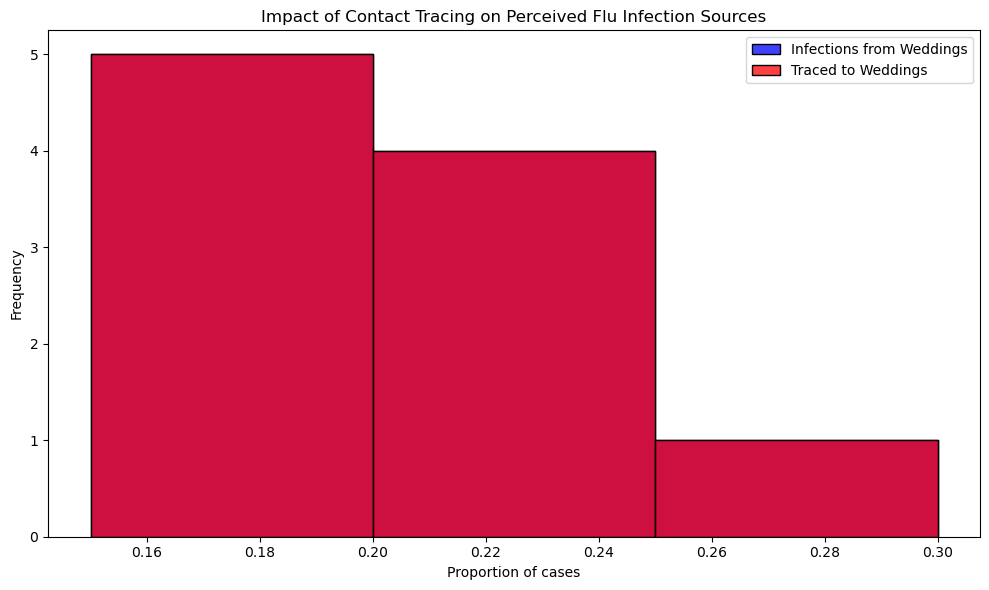

In [53]:
# Constants representing the parameters of the model (hypothetical #s: experimental design)
ATTACK_RATE = 0.10
TRACE_SUCCESS = 0.20
SECONDARY_TRACE_THRESHOLD = 2

def simulate_event(m):
  """
  Simulates the infection and tracing process for a series of events.
  
  This function creates a DataFrame representing individuals attending weddings and brunches,
  infects a subset of them based on the ATTACK_RATE, performs primary and secondary contact tracing,
  and calculates the proportions of infections and traced cases that are attributed to weddings.
  
  Parameters:
  - m: Dummy parameter for iteration purposes.
  - tells the function how many times (iterations) I want to simulate this event.
  
  Returns:
  - A tuple containing the proportion of infections and the proportion of traced cases
    that are attributed to weddings.
  """
  # Create DataFrame for people at events with initial infection and traced status
  events = ['wedding'] * 200 + ['brunch'] * 800
  ppl = pd.DataFrame({
      'event': events, # setting up a dataframe with event as a column of 200 weddings & 800 brunches
      'infected': False, # infected column false for every one as we are starting the experiment 
      'traced': np.nan  # Initially setting traced status as NaN (missing value), if we just put NaN -> pandas takes this as a string
  })


  # Explicitly set 'traced' column to nullable boolean type, 
  # since after we run experiment, the traced values will be either T or F, so we're just telling python it's a boolean val
  ppl['traced'] = ppl['traced'].astype(pd.BooleanDtype())


  # Infect a random subset of people
  infected_indices = np.random.choice(ppl.index, size=int(len(ppl) * ATTACK_RATE), replace=False)
  # np.random.choice(...) -> generating random numbers
  # len(ppl) * ATTACK_RATE -> comes out to be 100.0
  # randomly select 100 #'s from ppl.index in btwn 1-1000, don't repeat your selection
  ppl.loc[infected_indices, 'infected'] = True


  # Primary contact tracing: randomly decide which infected people get traced
  ppl.loc[ppl['infected'], 'traced'] = np.random.rand(sum(ppl['infected'])) < TRACE_SUCCESS
  # out of those 100 infected patients, 20% are traced successfully (T); 80% are not traced successfully (F)
  # illustrating binomial distribution (?)
  
  # ppl.loc[row, col]
  # we are selectiong only the traced col's, where the infected row is True
  # row option: ppl['infected'] -> T or F
  # col option: 'traced'

  # sum(ppl['infected']) -> 100 infected or True's
  # np.random.rand(...) -> generate a random integer btwn 1-100  


  # Secondary contact tracing based on event attendance
  event_trace_counts = ppl[ppl['traced'] == True]['event'].value_counts()
  # we are counting the # of successfully traced patients who were at either wedding or brunch
  # print(event_trace_counts)

  # counting the # of patients that were traced successfully that went to either a wedding or brunch
  events_traced = event_trace_counts[event_trace_counts >= SECONDARY_TRACE_THRESHOLD].index
  # print(events_traced)
  ppl.loc[ppl['event'].isin(events_traced) & ppl['infected'], 'traced'] = True
  # if there are >= 2 infected individuals at either wedding or brunch, set the traced col to True
  # ppl.loc[row, col] 


  # Calculate proportions of infections and traces attributed to each event type
  ppl['event_type'] = ppl['event'].str[0]  # 'w' for wedding, 'b' for brunch
  wedding_infections = sum(ppl['infected'] & (ppl['event_type'] == 'w'))
  brunch_infections = sum(ppl['infected'] & (ppl['event_type'] == 'b'))
  p_wedding_infections = wedding_infections / (wedding_infections + brunch_infections)


  wedding_traces = sum(ppl['infected'] & ppl['traced'] & (ppl['event_type'] == 'w'))
  brunch_traces = sum(ppl['infected'] & ppl['traced'] & (ppl['event_type'] == 'b'))
  p_wedding_traces = wedding_traces / (wedding_traces + brunch_traces)


  return p_wedding_infections, p_wedding_traces

# Run the simulation 10 times

results = [simulate_event(m) for m in range(10)]
props_df = pd.DataFrame(results, columns=["Infections", "Traces"])

# Plotting the results
plt.figure(figsize=(10, 6))
sns.histplot(props_df['Infections'], color="blue", alpha=0.75, binwidth=0.05, kde=False, label='Infections from Weddings')
sns.histplot(props_df['Traces'], color="red", alpha=0.75, binwidth=0.05, kde=False, label='Traced to Weddings')
plt.xlabel("Proportion of cases")
plt.ylabel("Frequency")
plt.title("Impact of Contact Tracing on Perceived Flu Infection Sources")
plt.legend()
plt.tight_layout()
plt.show()


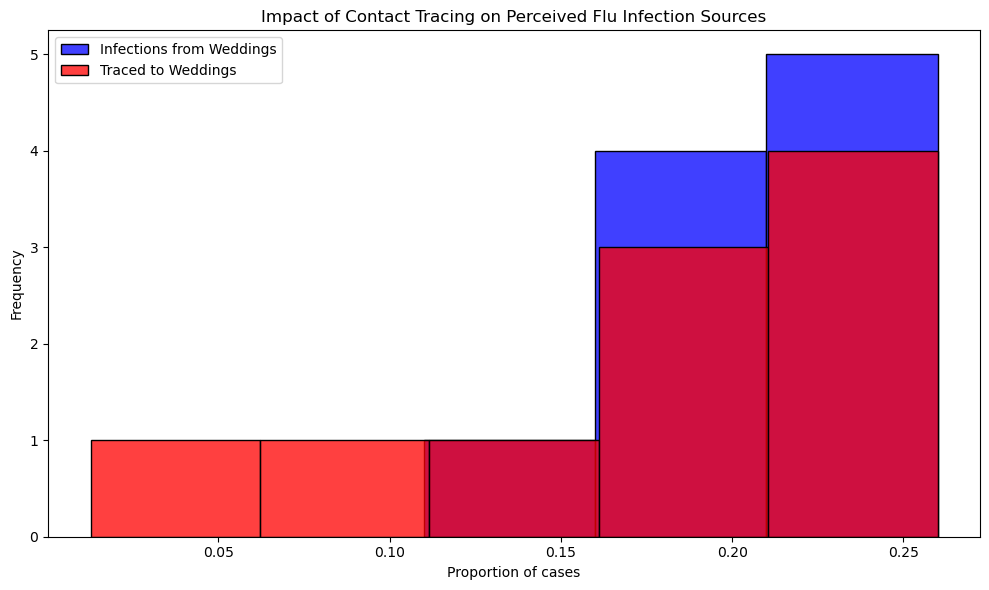

In [54]:
# Constants representing the parameters of the model (hypothetical #s: experimental design)
ATTACK_RATE = 0.10
TRACE_SUCCESS = 0.20
SECONDARY_TRACE_THRESHOLD = 2
np.random.seed(2)

def simulate_event(m):
  """
  Simulates the infection and tracing process for a series of events.
  
  This function creates a DataFrame representing individuals attending weddings and brunches,
  infects a subset of them based on the ATTACK_RATE, performs primary and secondary contact tracing,
  and calculates the proportions of infections and traced cases that are attributed to weddings.
  
  Parameters:
  - m: Dummy parameter for iteration purposes.
  - tells the function how many times (iterations) I want to simulate this event.
  
  Returns:
  - A tuple containing the proportion of infections and the proportion of traced cases
    that are attributed to weddings.
  """
  # Create DataFrame for people at events with initial infection and traced status
  events = ['wedding'] * 200 + ['brunch'] * 800
  ppl = pd.DataFrame({
      'event': events, # setting up a dataframe with event as a column of 200 weddings & 800 brunches
      'infected': False, # infected column false for every one as we are starting the experiment 
      'traced': np.nan  # Initially setting traced status as NaN (missing value), if we just put NaN -> pandas takes this as a string
  })


  # Explicitly set 'traced' column to nullable boolean type, 
  # since after we run experiment, the traced values will be either T or F, so we're just telling python it's a boolean val
  ppl['traced'] = ppl['traced'].astype(pd.BooleanDtype())


  # Infect a random subset of people
  infected_indices = np.random.choice(ppl.index, size=int(len(ppl) * ATTACK_RATE), replace=False)
  # np.random.choice(...) -> generating random numbers
  # len(ppl) * ATTACK_RATE -> comes out to be 100.0
  # randomly select 100 #'s from ppl.index in btwn 1-1000, don't repeat your selection
  ppl.loc[infected_indices, 'infected'] = True


  # Primary contact tracing: randomly decide which infected people get traced
  ppl.loc[ppl['infected'], 'traced'] = np.random.rand(sum(ppl['infected'])) < TRACE_SUCCESS
  # out of those 100 infected patients, 20% are traced successfully (T); 80% are not traced successfully (F)
  # illustrating binomial distribution (?)
  
  # ppl.loc[row, col]
  # we are selectiong only the traced col's, where the infected row is True
  # row option: ppl['infected'] -> T or F
  # col option: 'traced'

  # sum(ppl['infected']) -> 100 infected or True's
  # np.random.rand(...) -> generate a random integer btwn 1-100  


  # Secondary contact tracing based on event attendance
  event_trace_counts = ppl[ppl['traced'] == True]['event'].value_counts()
  # we are counting the # of successfully traced patients who were at either wedding or brunch
  # print(event_trace_counts)

  # counting the # of patients that were traced successfully that went to either a wedding or brunch
  events_traced = event_trace_counts[event_trace_counts >= SECONDARY_TRACE_THRESHOLD].index
  # print(events_traced)
  ppl.loc[ppl['event'].isin(events_traced) & ppl['infected'], 'traced'] = True
  # if there are >= 2 infected individuals at either wedding or brunch, set the traced col to True
  # ppl.loc[row, col] 


  # Calculate proportions of infections and traces attributed to each event type
  ppl['event_type'] = ppl['event'].str[0]  # 'w' for wedding, 'b' for brunch
  wedding_infections = sum(ppl['infected'] & (ppl['event_type'] == 'w'))
  brunch_infections = sum(ppl['infected'] & (ppl['event_type'] == 'b'))
  p_wedding_infections = wedding_infections / (wedding_infections + brunch_infections)


  wedding_traces = sum(ppl['infected'] & ppl['traced'] & (ppl['event_type'] == 'w'))
  brunch_traces = sum(ppl['infected'] & ppl['traced'] & (ppl['event_type'] == 'b'))
  p_wedding_traces = wedding_traces / (wedding_traces + brunch_traces)


  return p_wedding_infections, p_wedding_traces

# Run the simulation 10 times

results = [simulate_event(m) for m in range(10)]
props_df = pd.DataFrame(results, columns=["Infections", "Traces"])

# Plotting the results
plt.figure(figsize=(10, 6))
sns.histplot(props_df['Infections'], color="blue", alpha=0.75, binwidth=0.05, kde=False, label='Infections from Weddings')
sns.histplot(props_df['Traces'], color="red", alpha=0.75, binwidth=0.05, kde=False, label='Traced to Weddings')
plt.xlabel("Proportion of cases")
plt.ylabel("Frequency")
plt.title("Impact of Contact Tracing on Perceived Flu Infection Sources")
plt.legend()
plt.tight_layout()
plt.show()


In [2]:
results

[(0.14, np.float64(0.011494252873563218)),
 (0.14, np.float64(0.14)),
 (0.2, np.float64(0.2)),
 (0.21, np.float64(0.21)),
 (0.15, np.float64(0.011627906976744186)),
 (0.22, np.float64(0.22)),
 (0.23, np.float64(0.23)),
 (0.25, np.float64(0.25)),
 (0.14, np.float64(0.14)),
 (0.21, np.float64(0.0125)),
 (0.17, np.float64(0.17)),
 (0.21, np.float64(0.21)),
 (0.19, np.float64(0.19)),
 (0.24, np.float64(0.24)),
 (0.19, np.float64(0.19)),
 (0.14, np.float64(0.14)),
 (0.23, np.float64(0.23)),
 (0.13, np.float64(0.13)),
 (0.2, np.float64(0.2)),
 (0.16, np.float64(0.16)),
 (0.17, np.float64(0.17)),
 (0.2, np.float64(0.2)),
 (0.2, np.float64(0.2)),
 (0.22, np.float64(0.22)),
 (0.17, np.float64(0.17)),
 (0.14, np.float64(0.14)),
 (0.21, np.float64(0.21)),
 (0.21, np.float64(0.0125)),
 (0.15, np.float64(0.15)),
 (0.23, np.float64(0.23)),
 (0.22, np.float64(0.22)),
 (0.21, np.float64(0.21)),
 (0.24, np.float64(0.24)),
 (0.21, np.float64(0.21)),
 (0.27, np.float64(0.27)),
 (0.21, np.float64(0.21)),


In [18]:
results = [simulate_event(m) for m in range(2)]
props_df = pd.DataFrame(results, columns=["Infections", "Traces"])
# telling python i want to experiment twice


event
brunch     13
wedding     6
Name: count, dtype: int64
Index(['brunch', 'wedding'], dtype='object', name='event')
event
brunch     22
wedding     2
Name: count, dtype: int64
Index(['brunch', 'wedding'], dtype='object', name='event')


## Criteria

|Criteria|Complete|Incomplete|
|--------|----|----|
|Alteration of the code|The code changes made, made it reproducible.|The code is still not reproducible.|
|Description of changes|The author answered questions and explained the reasonings for the changes made well.|The author did not answer questions or explain the reasonings for the changes made well.|

## Submission Information
🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `23:59 - 22/06/2025`
* The branch name for your repo should be: `assignment-1`
* What to submit for this assignment:
    * This markdown file (`a1_sampling_and_reproducibility.ipynb`) should be populated with the code changed.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/sampling/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

#### Checklist:
- [ ] Create a branch called `assignment-1`.
- [ ] Ensure that the repository is public.
- [ ] Review [the PR description guidelines](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md#guidelines-for-pull-request-descriptions) and adhere to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via the help channel in Slack. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.
